In [1]:
%matplotlib inline
import os
import json
import glob
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import linalg as LA
import pandas as pd
from scipy.stats import linregress
import scipy.interpolate as scp_interpolate

from tsmoothie.smoother import LowessSmoother
from statsmodels.nonparametric.smoothers_lowess import lowess as  sm_lowess
import sys
print(sys.version)
rc_params = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)
# matplotlib.use('Agg')

/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_90744/3833954296.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


3.10.14 (main, Mar 19 2024, 21:46:16) [Clang 15.0.0 (clang-1500.3.9.4)]


In [2]:
class Line:
    def __init__(self, x, y, name, style, color, secondary_axis=False, **kwargs):
        self.x: list = x
        self.y: list = y
        self.name: str = name
        self.style: str = style
        self.color: str = color
        self.secondary_axis = secondary_axis
        self.kwargs = kwargs
    
    def get_plot_configs(self):
        args = (self.x, self.y)
        kwargs = {"linestyle": self.style, "color": self.color, "label": self.name, "linewidth": self.kwargs.get("linewidth", 1)}
        return args, kwargs
    
    def get_text_configs(self):
        configs = self.kwargs.get("text")
        args = (configs["x"], configs["y"], configs["s"])
        kwargs = self.extract_specific_keys_values(["x", "y", "s"], input_dict=configs, reverse=True)
        print("get_text_configs", args, kwargs)
        return args, kwargs

    def extract_specific_keys_values(self, keys, input_dict=None, reverse=False):
        """
        Extracts specific keys and their values from the given dictionary.
    
        Args:
        input_dict (dict): The dictionary to extract data from.
        keys (list): A list of keys to extract from the dictionary.
    
        Returns:
        dict: A dictionary containing only the specified keys and their values.
        """
        if not input_dict:
            input_dict = self.kwargs
        if reverse:
            return {key: input_dict[key] for key in input_dict if key not in keys}
        else:
            return {key: input_dict[key] for key in input_dict if key in input_dict}
        
def set_ax_design(
    ax,
    xlabel: dict = None,
    ylabel: dict = None,
    xaxis: dict = None,
    yaxis: dict = None,
    xrange: list = None,
    yrange: list = None,
    xtick_params: dict = None,
    ytick_params: dict = None,
    axis_visibility: dict = None
):
    # Setting labels
    if xlabel:
        ax.set_xlabel(**xlabel)
    if ylabel:
        ax.set_ylabel(**ylabel)
        
    # Setting the axis labels
    if xaxis and xaxis.get("set_label_coords"):
        ax.xaxis.set_label_coords(*xaxis.get("set_label_coords"))
    if yaxis and yaxis.get("set_label_coords"):    
        ax.yaxis.set_label_coords(*yaxis.get("set_label_coords"))
    
    # Setting ticks
    if xtick_params:
        ax.tick_params(axis='x', **xtick_params)
    if ytick_params:
        ax.tick_params(axis='y', **ytick_params)
    
    # Setting the range for the x-axis
    if xrange:
        ax.axis(xmin=xrange[0], xmax=xrange[1])  # Set the x-axis to display
    
    # Setting the range for the y-axis
    if yrange:
        ax.axis(ymin=yrange[0], ymax=yrange[1])  # Set the y-axis to display

    # Removing upper and right spines
    if axis_visibility:
        for direction, visibility in axis_visibility.items():
            ax.spines[direction].set_visible(visibility)

def plot_matplotlib(
    lines: list[Line],
    xlabel: dict,
    ylabel: dict,
    xaxis: dict,
    yaxis: dict,
    xtick_params: dict,
    ytick_params: dict,
    xrange: list,
    yrange: list,
    axis_visibility: dict,
    image_name: str,
    path: str,
    title: str = None,
    vertical: list = None,
    horizontal: list = None,
    legend_props: dict | None = None,
    secondary_axis_needed: bool = False,
    second_axis: dict = None,
    grid: dict = None,
    savefig: dict = None
):
    fig, ax1 = plt.subplots()
    set_ax_design(ax1, xlabel=xlabel, ylabel=ylabel, xaxis=xaxis, yaxis=yaxis, xtick_params=xtick_params, ytick_params=ytick_params, xrange=xrange, yrange=yrange, axis_visibility=axis_visibility)
    if secondary_axis_needed:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        set_ax_design(ax2, **second_axis)
    
    # Plotting the lines
    for line in lines:
        ax = ax2 if line.secondary_axis else ax1
        args, kwargs = line.get_plot_configs()
        ax.plot(*args, **kwargs)
        if line.kwargs.get("text"):
            args, kwargs = line.get_text_configs()
            ax.text(*args, **kwargs)
    
    # Adding vertical lines and filling the area between them
    if vertical and len(vertical) == 2 and horizontal and len(horizontal) == 2:
        # ax1.axvline(x=vertical[0], color='red', linestyle='-')
        # ax1.axvline(x=vertical[1], color='red', linestyle='-')
        ax1.fill_betweenx(y=np.arange(horizontal[0], horizontal[1], 0.0001), x1=vertical[0], x2=vertical[1], color='red', alpha=0.3, lw=0)
    if grid is not None:
        ax1.grid(*grid)
    if title:
        fig.title(title)
    if legend_props is not None:
        fig.legend(**legend_props)
    fig.tight_layout()
    
    # Saving the plot as a PDF file
    original_image_name = os.path.join(path, f"original_{image_name}")
    compressed_image_name = os.path.join(path, image_name)
    print(f"Saved image {original_image_name}")
    if savefig is None:
        savefig = {
            "format": "pdf"
        }        
    fig.savefig(original_image_name, **savefig)
    
    # Show plot
    fig.show()
    # Compress image
    command = f"gs -sDEVICE=pdfwrite -dCompatibilityLevel=1.5 -dPDFSETTINGS=/screen -dNOPAUSE -dBATCH -sOutputFile={compressed_image_name} {original_image_name}"
    os.system(command)

def sort_names(image_files):
    file_names = [os.path.basename(string) for string in image_files]
    times = [(float(re.findall(r"\d+\.\d+", string)[0]), string) for string in file_names]
    times = sorted(times, key=lambda x: x[0])
    print(f"Time range: {times[0]} -- {times[-1]}")
    image_files = [t[1] for t in times]
    return image_files

def give_time(file) -> float:
    filename = os.path.basename(file)
    time = re.findall(r"\d+\.\d+", filename)[0]
    return float(time)

def interpolate_by_ngb(arr, mask_val=None, fun=None):
    mask = np.isnan(arr) if mask_val is None else arr == mask_val
    if fun is not None:
        mask = fun(arr) | mask
    arr[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), arr[~mask])
    return arr

def signal_filtering(x_original, y_original, intervals: list[list[int, int]], **kwargs):
    x_in = x_original.copy()
    y_in = y_original.copy()
    for xmin, xmax in intervals:
        ind = (x_in > xmin) & (x_in < xmax)
        xx = x_in[ind]
        yy = y_in[ind]
        sm_x, sm_y = sm_lowess(yy, xx, **kwargs).T
        # Apply the combined mask to x_in and y_in
        x_in[ind] = sm_x
        y_in[ind] = sm_y
    return x_in, y_in

class Data:
    def __init__(self, path, skip_times=None):
        self.surface_tension = 0.008381299652  # dimensionless 1/Re*Ca_mod
        self.rho1 = 1
        self.rho2 = 1./997
        self.krho = (self.rho1 - self.rho2)/self.rho2
        self.critical_volume = 0.1
        self.path = path
        self.curvature = dict()
        with open(os.path.join(path, "../output_sliced_Rmax_U.json"), "r") as f:
            self.curvature = json.load(f)
        new_dict = dict()
        # Iterate over the time points
        for i, time in enumerate(self.curvature["t"]):
            if time not in skip_times:
                new_dict[time] = {key: value[i] for key, value in self.curvature.items()}
        self.curvature["struct"] = new_dict
        self.curvature["t"] = self.d2l(self.curvature["struct"], lambda x: x.get("t"))
        self.curvature["curvature_tip"] = self.d2l(self.curvature["struct"], lambda x: np.abs(x.get("curvature_tip")))
        self.curvature["U_tip"] = self.d2l(self.curvature["struct"], lambda x: x.get("U_tip"))
        self.curvature["x_tip"] = self.d2l(self.curvature["struct"], lambda x: x.get("x_tip"))
        self.curvature["rmax"] = self.d2l(self.curvature["struct"], lambda x: x.get("rmax"))
        
        self.table = {"df": pd.read_csv(os.path.join(path, 'for_excel_table.txt'), sep=' |\t', header=0)}
        self.table["t"] = self.table["df"]["t"].values
        self.table["tmin"] = self.table["t"].min()
        self.table["tmax"] = self.table["t"].max()
        self.table["UmeanV"] = self.table["df"]["UmeanV"].values

        self.metadata = {"t": [], "struct": {}}
        metadata_names = glob.glob(os.path.join(path, "metadata_t=*.json"), recursive = False)
        self.metadata["metadata_names"] = sort_names(metadata_names)
        for ifile, file in enumerate(self.metadata["metadata_names"]):
            time = give_time(file)
            with open(os.path.join(path, file), "r") as f:
                self.metadata["struct"][time] = json.load(f)
        self.metadata["t"] = self.d2l(self.metadata["struct"], lambda x: x.get("timestep"))
        self.metadata["deltaE"] = self.d2l(self.metadata["struct"], lambda x: self.krho*x.get("Ekg_mean_tube", np.nan)*x.get("volume_tube", np.nan))
        self.metadata["deltaE"] = interpolate_by_ngb(self.metadata["deltaE"], fun = lambda x: x > 100)
        
        for i in [0, 1]:
            get_n_part = lambda x: Data.get_n_part(x, i, self.critical_volume)
            get_additive_var = lambda x: Data.get_additive_var(x, i, self.critical_volume)
            self.metadata[f"bubble_volume_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_additive_var(x).get("Volume", np.nan))
            self.metadata[f"bubble_area_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_additive_var(x).get("Area", np.nan))
            self.metadata[f"bubble_direct_area_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_additive_var(x).get("DirectArea", np.nan))
            self.metadata[f"bubble_vsize_{i}"] = self.d2l(self.metadata["struct"], lambda x: 0.5*(abs(get_n_part(x).get("len_x", np.nan))+abs(get_n_part(x).get("len_y", np.nan))))
            self.metadata[f"bubble_xmean_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_n_part(x).get("x_mean", [np.nan, np.nan, np.nan])[2])
            self.metadata[f"bubble_umean_x_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_n_part(x).get("u_mean", [np.nan, np.nan, np.nan])[2])
            self.metadata[f"bubble_umean_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_n_part(x).get("u_mean", [np.nan, np.nan, np.nan]))
            self.metadata[f"bubble_length_{i}"] = self.d2l(self.metadata["struct"], lambda x: get_n_part(x).get("len_z", np.nan))
            self.metadata[f"bubble_kinetic_energy_{i}"] = self.d2l(self.metadata["struct"], lambda x: self.krho*get_n_part(x).get("Ekg_mean", np.nan)*get_n_part(x).get("Volume", np.nan))
            self.metadata[f"bubble_surface_energy_{i}"] = self.calc_Es(i)
            
            # print(f'rho={self.rho} Vb={self.metadata[f"bubble_volume_{i}"]} U={self.metadata[f"bubble_umean_{i}"]} Unorm={LA.norm(self.metadata[f"bubble_umean_{i}"], axis=1)} Ek={self.metadata[f"bubble_kinetic_energy_{i}"]}')
        
        self.metadata["bubble_volume"] = []
        self.metadata["bubble_area"] = []
        self.metadata["bubble_direct_area"] = []
        self.metadata["bubble_kinetic_energy"] = []
        for time, struct in self.metadata["struct"].items():
            print("t=", time, "len=", len(struct["parts"]))
            self.metadata["bubble_volume"].append(sum([v.get("Volume", 0) for k,v in struct["parts"].items()]))
            self.metadata["bubble_area"].append(sum([v.get("Area", 0) for k,v in struct["parts"].items()]))
            self.metadata["bubble_direct_area"].append(sum([v.get("DirectArea", 0) for k,v in struct["parts"].items()]))
            # self.metadata["bubble_kinetic_energy"].append(sum([self.krho*v.get("Ekg_mean", 0) for k,v in struct["parts"].items()]))
        self.metadata["bubble_kinetic_energy"] = 0
        self.metadata["bubble_surface_energy"] = 0
        for i in [0, 1]:
            self.metadata["bubble_kinetic_energy"] += np.where(~np.isnan(self.metadata[f"bubble_kinetic_energy_{i}"]), self.metadata[f"bubble_kinetic_energy_{i}"], 0)
            self.metadata["bubble_surface_energy"] += np.where(~np.isnan(self.metadata[f"bubble_surface_energy_{i}"]), self.metadata[f"bubble_surface_energy_{i}"], 0)
        self.metadata["bubble_kinetic_energy"] = interpolate_by_ngb(self.metadata["bubble_kinetic_energy"], mask_val=0)
        
        self.metadata["bubble_volume"] = np.asarray(self.metadata["bubble_volume"])
        self.metadata["bubble_volume_others"] = self.metadata["bubble_volume"] - self.metadata["bubble_volume_0"] - self.metadata["bubble_volume_1"]
        self.metadata["bubble_direct_area"] = np.asarray(self.metadata["bubble_direct_area"])
        self.metadata["bubble_area"] = np.asarray(self.metadata["bubble_area"])
        mask = (np.isnan(self.metadata["bubble_area"])) | (self.metadata["bubble_area"] > 1e+2)
        self.metadata['bubble_area'][mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), self.metadata["bubble_area"][~mask])
        self.metadata["bubble_kinetic_energy"] = np.asarray(self.metadata["bubble_kinetic_energy"])
        self.metadata["bubble_surface_energy"] = self.surface_tension*self.metadata["bubble_area"]
        self.metadata["bubble_surface_energy_direct"] = self.surface_tension*self.metadata["bubble_direct_area"]
        self.metadata["delta_min"] = self.d2l(self.metadata["struct"], lambda x: x.get("delta_min"))
        self.metadata["delta_mean"] = self.d2l(self.metadata["struct"], lambda x: x.get("delta_mean"))
        self.metadata["delta_max"] = self.d2l(self.metadata["struct"], lambda x: x.get("delta_max"))
        self.metadata["unose"] = self.d2l(self.metadata["struct"], lambda x: x.get("umag")[np.asarray(x.get("xp")).argmax()] if x.get("umag") else np.nan)
        # self.metadata["unose"] = self.d2l(self.metadata["struct"], lambda x: x.get("umag")[np.asarray(x.get("xp")).argmax()] if x.get("umag") else None)
        self.metadata["unose"] = interpolate_by_ngb(self.metadata["unose"])
        self.metadata["t"], self.metadata["unose"] = signal_filtering(self.metadata["t"], self.metadata["unose"], intervals = [(6, 12)], frac=0.2, it=5, )
        
    @staticmethod     
    def get_n_part(x, i, critical_volume):
        if len(x["parts"]) <= i:
            return {}
        index = list(x["parts"].keys())[i]
        return x["parts"].get(index, {}) if len(x["parts"]) > i and x["parts"].get(index, {}).get("Volume", 0) > critical_volume else {}
    
    @staticmethod
    def get_additive_var(x, i, critical_volume):
        if len(x["parts"]) <= i:
            return {}
        index = list(x["parts"].keys())[i]
        return x["parts"].get(index, {}) if len(x["parts"]) > i and x["parts"].get(index, {}).get("Volume", 0) > critical_volume else {}

    def d2l(self, d, fun):
        return np.asarray([fun(v) for v in d.values()])

    @staticmethod
    def calc_unose(struct):
        index = struct["xp"].idxmax()
        return struct["umag"][index]

    def calc_Es(self, i):
        return self.surface_tension*self.metadata[f"bubble_area_{i}"]
    
    # def calc_Ek(self, i):
    #     return self.rho*self.metadata[f"bubble_volume_{i}"]*LA.norm(self.metadata[f"bubble_umean_{i}"], axis=1)**2/2
        

# Input read files

In [3]:
path = os.path.join(os.getenv("HOME"), "basilisk/work/tube/res27/")
print(f"path: {path}")
data = Data(path=path, skip_times=[7.76])

path: /Users/evgeniisharaborin/basilisk/work/tube/res27/
Time range: (0.17413, 'metadata_t=0.17413.json') -- (11.9197, 'metadata_t=11.9197.json')


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_90744/3948380044.py:206: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  self.table = {"df": pd.read_csv(os.path.join(path, 'for_excel_table.txt'), sep=' |\t', header=0)}


t= 0.17413 len= 1
t= 0.362973 len= 1
t= 0.556045 len= 1
t= 0.749304 len= 1
t= 0.942563 len= 1
t= 1.10827 len= 1
t= 1.27861 len= 2
t= 1.44432 len= 1
t= 1.62507 len= 1
t= 1.78192 len= 2
t= 1.9472 len= 2
t= 2.11013 len= 2
t= 2.27704 len= 1
t= 2.43603 len= 2
t= 2.60158 len= 1
t= 2.76106 len= 1
t= 2.91823 len= 1
t= 3.07685 len= 1
t= 3.24171 len= 2
t= 3.40416 len= 2
t= 3.56719 len= 2
t= 3.7255 len= 2
t= 3.87939 len= 1
t= 4.03126 len= 2
t= 4.18057 len= 1
t= 4.33204 len= 1
t= 4.47748 len= 1
t= 4.62203 len= 1
t= 4.76552 len= 2
t= 4.89731 len= 1
t= 5.03192 len= 2
t= 5.17124 len= 1
t= 5.30134 len= 1
t= 5.43179 len= 1
t= 5.56657 len= 1
t= 5.70517 len= 1
t= 5.83575 len= 2
t= 5.97012 len= 3
t= 6.10407 len= 1
t= 6.24837 len= 2
t= 6.38689 len= 1
t= 6.52373 len= 1
t= 6.66408 len= 2
t= 6.6928 len= 2
t= 6.72528 len= 1
t= 6.75937 len= 1
t= 6.79305 len= 2
t= 6.82811 len= 1
t= 6.86327 len= 1
t= 6.89764 len= 1
t= 6.93211 len= 1
t= 6.96638 len= 1
t= 7.00014 len= 2
t= 7.03331 len= 2
t= 7.06585 len= 1
t= 7.0979

In [ ]:
data.metadata

In [ ]:
# data.metadata
data.metadata["t"], data.metadata["bubble_direct_area_0"], data.metadata["bubble_direct_area_0"]

In [ ]:
data.metadata["t"], data.metadata["bubble_volume"], data.metadata["bubble_volume_0"], data.metadata["bubble_volume_1"]

In [418]:
# data.metadata['bubble_umean_x_0']

# Plot $U_\text{mean}$, $U_\text{nose}$ and $U_\text{tail}$

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_u_nose_mean_tip_markers2.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Processing pages 1 through 1.
Page 1


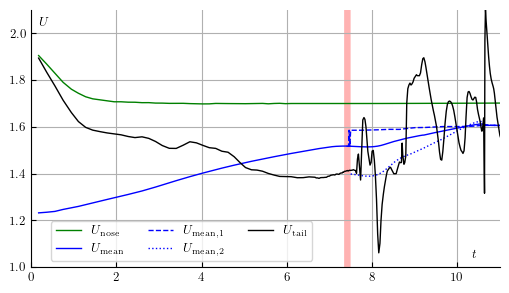

In [634]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)
bf_br = data.table["t"] < 7.4
af_br = data.metadata["t"] >= 7.4
lines = [
    Line(x=data.metadata["t"], y=data.metadata["unose"], name=r'$U_{\text{nose}}$', style='solid', color='green', linewidth=1),
    Line(x=data.table["t"], y=data.table["UmeanV"], name=r'$U_{\text{mean}}$', style='solid', color='blue'),
    # Line(x=data.table["t"][bf_br], y=data.table["UmeanV"][bf_br], name=r'$U_{\text{mean}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_umean_x_0'][af_br], name=r'$U_{\text{mean,1}}$', style='dashed', color='blue', linewidth=1),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_umean_x_1'][af_br], name=r'$U_{\text{mean,2}}$', style='dotted', color='blue', linewidth=1),
    Line(x=data.curvature["t"], y=data.curvature['U_tip'], name=r'$U_{\text{tail}}$', style='solid', color='black', linewidth=1),
]

plot_matplotlib(
    lines=lines,
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$U$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
    xaxis={"set_label_coords": (0.95, 0.07)},
    yaxis={"set_label_coords": (0.025, 0.97)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in'},
    xrange=[0, 11],
    yrange=[1., 2.1],
    axis_visibility={'top': False, 'right': False},
    image_name="u_nose_mean_tip_markers2.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 2.25],
    legend_props={"loc": (0.1,0.11), "ncol": 3},
    grid={"axis":"both" }
)

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_u_nose_mean_tip_half.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


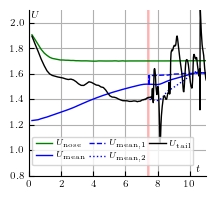

In [635]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 6,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}
matplotlib.rcParams.update(rc_params)
bf_br = data.table["t"] < 7.4
af_br = data.metadata["t"] >= 7.4
lines = [
    Line(x=data.metadata["t"], y=data.metadata["unose"], name=r'$U_{\text{nose}}$', style='solid', color='green', linewidth=1),
    Line(x=data.table["t"], y=data.table["UmeanV"], name=r'$U_{\text{mean}}$', style='solid', color='blue'),
    # Line(x=data.table["t"][bf_br], y=data.table["UmeanV"][bf_br], name=r'$U_{\text{mean}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_umean_x_0'][af_br], name=r'$U_{\text{mean,1}}$', style='dashed', color='blue', linewidth=1),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_umean_x_1'][af_br], name=r'$U_{\text{mean,2}}$', style='dotted', color='blue', linewidth=1),
    Line(x=data.curvature["t"], y=data.curvature['U_tip'], name=r'$U_{\text{tail}}$', style='solid', color='black', linewidth=1),
]

plot_matplotlib(
    lines=lines,
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$U$', 'verticalalignment': 'top', 'y': 1, 'rotation':0},
    xaxis={"set_label_coords": (0.97, 0.06)},
    yaxis={"set_label_coords": (0.03, 0.99)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in'},
    xrange=[0, 11],
    yrange=[0.8, 2.1],
    axis_visibility={'top': False, 'right': False},
    image_name="u_nose_mean_tip_half.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0.45, 2.25],
    legend_props={"loc": (0.15 ,0.17), "ncol": 3, "columnspacing": 0.5, "handletextpad": 0.4},
    grid={"axis":"both" },
    savefig = { "format": "pdf", "bbox_inches": "tight", "pad_inches": 0} 
)

In [649]:
import statsmodels.stats.api as sms
t = data.metadata["t"]
tt = data.table["t"]
for label, a in [
    ("Unose_af_br", data.metadata["unose"][af_br]),
    ("Umean_af_br", data.table["UmeanV"][(tt > 7.34) & (tt < 8)]),
]:
    conf = sms.DescrStatsW(a).tconfint_mean(alpha=0.05)
    print(label, (conf[1] + conf[0])/2, (conf[1] - conf[0])/2)
bf_br = data.curvature["t"] < 7.4
print(f"Utail min: {data.curvature['U_tip'][bf_br].min()} max: {data.curvature['U_tip'][bf_br].max()}")

Unose_af_br 1.7054273355643184 0.0013386290522927613
Umean_af_br 1.5161017562512153 0.0005757492988294199
Utail min: 1.379592096508279 max: 1.8941705817823746


# Delta

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_delta.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


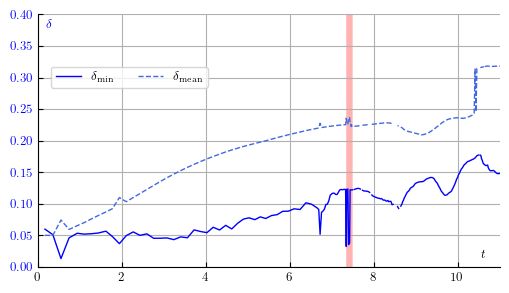

In [636]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)

lines = [
    Line(x=data.metadata["t"], y=data.metadata['delta_min'], name=r'$\delta_{\text{min}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['delta_mean'], name=r'$\delta_{\text{mean}}$', style='dashed', color='royalblue'), #, text={"x": 10.7, "y": 8.5, "s": "I"}
    # Line(x=data.metadata["t"], y=data.metadata['delta_max'], name=r'$\delta_{\text{max}}$', style='dashdot', color='deepskyblue'), #, text={"x": 10.7, "y": 5.1, "s": "II"}
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$\delta$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.025, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 11],
    yrange=[0,0.4],
    axis_visibility={'top': False, 'right': False},
    image_name="delta.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 2.25],
    legend_props={"loc": (0.1,0.7), "ncol": 2},
    grid={"axis":"both"}
)


# Vsize of bubbles (vertical size)

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_vsize.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


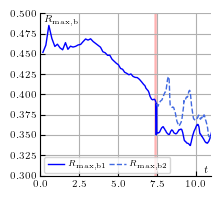

In [637]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 6,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1,
    'text.usetex': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}
matplotlib.rcParams.update(rc_params)

lines = [
    Line(x=data.metadata["t"], y=0.5*data.metadata['bubble_vsize_0'], name=r'$R_{\text{max,b1}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=0.5*data.metadata['bubble_vsize_1'], name=r'$R_{\text{max,b2}}$', style='dashed', color='royalblue'),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$R_{\text{max,b}}$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'black'},
    xaxis={"set_label_coords": (0.98, 0.06)},
    yaxis={"set_label_coords": (0.12, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "black"},
    xrange=[0, 11],
    yrange=[0.3,0.5],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_vsize.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 2.25],
    legend_props={"loc": (0.2,0.13), "ncol": 2, "columnspacing": 0.5, "handletextpad": 0.4},
    grid={"axis":"both"},
    savefig = { "format": "pdf", "bbox_inches": "tight", "pad_inches": 0} 
) 


In [382]:
# data.metadata['delta_min']
# 0.556045
aa = np.asarray(data.metadata['struct'][0.556045]["yp"])
aaa = np.absolute(aa).max()
0.5 - aaa, data.metadata['delta_min'][2]

(0.02427259087562561, 0.013390087607053458)

In [391]:
dd = 30/2**13
# deltamin(all time), deltamin(t>0.6), diam 
0.013390087607053458/dd, 0.05/dd, 1/dd, 

(3.656386589232731, 13.653333333333334, 273.06666666666666)

# Plot $A(t)$ and $V(t)$

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_area_volume.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_area.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


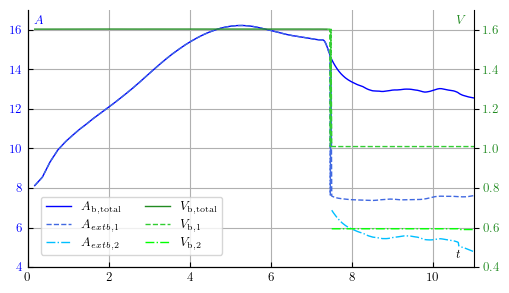

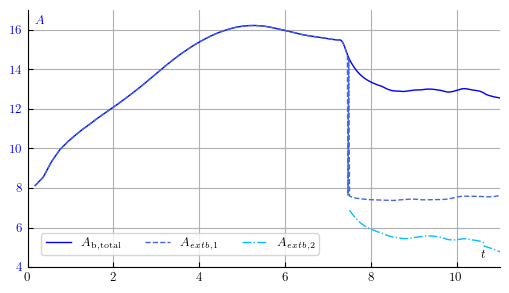

In [638]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)
bf_br = data.metadata["t"] < 7.4
af_br = data.metadata["t"] >= 7.4
lines = [
    Line(x=data.metadata["t"], y=data.metadata['bubble_area'], name=r'$A_{\text{b,total}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_0'], name='$A_{\text{b,1}}$', style='dashed', color='royalblue'), #, text={"x": 10.7, "y": 8.5, "s": "I"}
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_1'], name='$A_{\text{b,2}}$', style='dashdot', color='deepskyblue'), #, text={"x": 10.7, "y": 5.1, "s": "II"}
    
    Line(x=data.metadata["t"][bf_br], y=data.metadata['bubble_volume'][bf_br], name=r'$V_{\text{b,total}}$', style='solid', color='forestgreen', linewidth=1, secondary_axis=True),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_volume_0'][af_br], name=r'$V_{\text{b,1}}$', style='dashed', color='limegreen', linewidth=1, secondary_axis=True),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_volume_1'][af_br], name=r'$V_{\text{b,2}}$', style='dashdot', color='lime', linewidth=1, secondary_axis=True),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$A$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.025, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 11],
    yrange=[4, 17],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_area_volume.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0.45, 2.25],
    legend_props={"loc": (0.08,0.13), "ncol": 2},
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$V$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (0.97, 0.98)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0.4, 1.7],
        "axis_visibility": {'top': False}
    },
    grid={"axis":"both" }
)

plot_matplotlib(
    lines=lines[:3], 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$A$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.025, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 11],
    yrange=[4, 17],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_area.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0.45, 2.25],
    legend_props={"loc": (0.08,0.13), "ncol": 3},
    grid={"axis":"both" }
)

In [658]:
import statsmodels.stats.api as sms
t = data.metadata["t"]
tt = data.table["t"]
bf_br = data.metadata["t"] < 7.2
af_br = data.metadata["t"] >= 7.6
for label, a in [
    ("bubble_volume", data.metadata["bubble_volume"][bf_br]),
    ("bubble_volume_0", data.metadata["bubble_volume_0"][af_br]),
    ("bubble_volume_1", data.metadata["bubble_volume_1"][af_br]),
    ("bubble_volume_others", data.metadata["bubble_volume_others"][af_br]),
]:
    conf = sms.DescrStatsW(a).tconfint_mean(alpha=0.05)
    print(label, (conf[1] + conf[0])/2, (conf[1] - conf[0])/2)

index = data.metadata['bubble_area'].argmax()
print(f"Amax time: {data.metadata['t'][index]}")

bubble_volume 1.6034430669644393 1.7591378711712125e-05
bubble_volume_0 1.009503380658582 3.5899476173995026e-06
bubble_volume_1 0.592162254165112 0.00025668693543268173
bubble_volume_others 0.0015947052835691364 0.00025327967220257716
Amax time: 5.30134


# Plot $E_{surf}(t)$ and $E_k$

Pure Hagen-Poiseuille flow:

$E_k=\frac23 \rho \pi L U_{mean}^2  R^2 = \frac16 \rho \pi L U_{mean}^2  d^2 = $

$E_k=\pi L/6 = 15.7$

$e_k = E_k/V_{tube} = \frac{2}{3} \rho U_{mean}^2$

$E_{k, num}=\int \frac12 \rho v^2 dV$

$\Delta E = \frac{\rho_1 - \rho_2}{\rho_2}\int \frac12 (1 - \varphi) u^2 dV$

https://www.tec-science.com/mechanics/gases-and-liquids/energetic-analysis-of-the-hagen-poiseuille-law/

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_kinetic_surface_energy.pdf


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


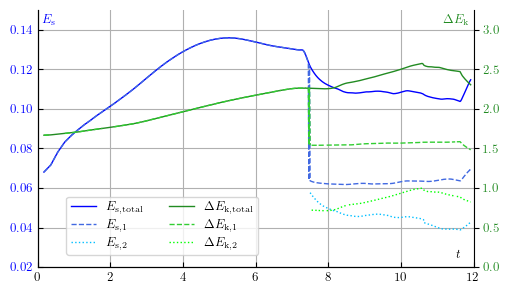

In [660]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 3]
}
matplotlib.rcParams.update(rc_params)

lines = [
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy'], name=r'$E_{\text{s,total}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy_0'], name=r'$E_{\text{s,1}}$', style='dashed', color='royalblue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy_1'], name=r'$E_{\text{s,2}}$', style='dotted', color='deepskyblue'),
    
    # Line(x=data.metadata["t"], y=data.metadata['deltaE'], name=r'$E_{\text{k,total}}$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy'], name=r'$\Delta E_{\text{k,total}}$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy_0'], name=r'$\Delta E_{\text{k,1}}$', style='dashed', color='limegreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy_1'], name=r'$\Delta E_{\text{k,2}}$', style='dotted', color='lime', secondary_axis=True),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$E_{\text{s}}$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.025, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 12],
    yrange=[0.02, 0.15],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_kinetic_surface_energy.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0.45, 2.25],
    legend_props={"loc": (0.13,0.13), "ncol": 2},
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$\Delta E_{\text{k}}$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (0.96, 0.98)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0., 3.25],
        "axis_visibility": {'top': False}
    },
    grid={"axis":"both" }
)

In [670]:
arr = data.metadata['bubble_kinetic_energy_1']
ind = np.where(np.isnan(arr), 0, arr).argmax()
print(f"Ek max2 t={data.metadata['t'][ind]}")

Ek max2 t=10.5673


# A and Rmax

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_vsize_area.pdf


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_31820/3948380044.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


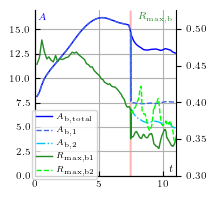

In [14]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 6,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1,
    'text.usetex': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}
matplotlib.rcParams.update(rc_params)

lines = [
    Line(x=data.metadata["t"], y=data.metadata['bubble_area'], name=r'$A_{\text{b,total}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_0'], name=r'$A_{\text{b,1}}$', style='dashed', color='royalblue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_1'], name=r'$A_{\text{b,2}}$', style='dashdot', color='deepskyblue'),
    Line(x=data.metadata["t"], y=0.5*data.metadata['bubble_vsize_0'], name=r'$R_{\text{max,b1}}$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=0.5*data.metadata['bubble_vsize_1'], name=r'$R_{\text{max,b2}}$', style='dashed', color='lime', secondary_axis=True),

]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$A$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.98, 0.06)},
    yaxis={"set_label_coords": (0.05, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "black"},
    xrange=[0, 11],
    yrange=[0, 17],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_vsize_area.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 17],
    legend_props={"loc": (0.15,0.1), "ncol": 1, "columnspacing": 0.5, "handletextpad": 0.4},
    grid={"axis":"both"},
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$R_{\text{max,b}}$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (0.85, 0.98)},
        'ytick_params': {'labelcolor': 'black'},
        'yrange': [0.3,0.526],
        "axis_visibility": {'top': False}
    },
    savefig = { "format": "pdf", "bbox_inches": "tight", "pad_inches": 0} 
) 


# Half Area/Volume and Es/Ek

Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_area_volume_half.pdf


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_11400/3297065297.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_bubble_kinetic_surface_energy_half.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


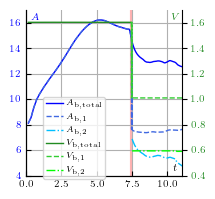

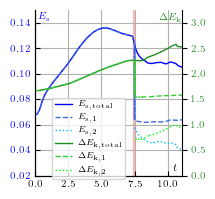

In [651]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 6,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1,
    'text.usetex': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}
matplotlib.rcParams.update(rc_params)
bf_br = data.metadata["t"] < 7.4
af_br = data.metadata["t"] >= 7.4
lines = [
    Line(x=data.metadata["t"], y=data.metadata['bubble_area'], name=r'$A_{\text{b,total}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_0'], name=r'$A_{\text{b,1}}$', style='dashed', color='royalblue'), #, text={"x": 10.7, "y": 8.5, "s": "I"}
    Line(x=data.metadata["t"], y=data.metadata['bubble_area_1'], name=r'$A_{\text{b,2}}$', style='dashdot', color='deepskyblue'), #, text={"x": 10.7, "y": 5.1, "s": "II"}
    
    Line(x=data.metadata["t"][bf_br], y=data.metadata['bubble_volume'][bf_br], name=r'$V_{\text{b,total}}$', style='solid', color='forestgreen', linewidth=1, secondary_axis=True),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_volume_0'][af_br], name=r'$V_{\text{b,1}}$', style='dashed', color='limegreen', linewidth=1, secondary_axis=True),
    Line(x=data.metadata["t"][af_br], y=data.metadata['bubble_volume_1'][af_br], name=r'$V_{\text{b,2}}$', style='dashdot', color='lime', linewidth=1, secondary_axis=True),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$A$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.06, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 11],
    yrange=[4, 17],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_area_volume_half.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 100],
    legend_props={"loc": (0.2,0.1), "ncol": 1, "columnspacing": 0.5, "handletextpad": 0.4},
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$V$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (0.95, 0.98)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0.4, 1.7],
        "axis_visibility": {'top': False}
    },
    grid={"axis":"both" },
    savefig = { "format": "pdf", "bbox_inches": "tight", "pad_inches": 0} 
)

#  Es/Ek
lines = [
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy'], name=r'$E_{\text{s,total}}$', style='solid', color='blue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy_0'], name=r'$E_{\text{s,1}}$', style='dashed', color='royalblue'),
    Line(x=data.metadata["t"], y=data.metadata['bubble_surface_energy_1'], name=r'$E_{\text{s,2}}$', style='dotted', color='deepskyblue'),
    
    # Line(x=data.metadata["t"], y=data.metadata['deltaE'], name=r'$E_{\text{k,total}}$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy'], name=r'$\Delta E_{\text{k,total}}$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy_0'], name=r'$\Delta E_{\text{k,1}}$', style='dashed', color='limegreen', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_kinetic_energy_1'], name=r'$\Delta E_{\text{k,2}}$', style='dotted', color='lime', secondary_axis=True),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$E_{\text{s}}$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'blue'},
    xaxis={"set_label_coords": (0.97, 0.07)},
    yaxis={"set_label_coords": (0.06, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 11],
    yrange=[0.02, 0.15],
    axis_visibility={'top': False, 'right': False},
    image_name="bubble_kinetic_surface_energy_half.pdf",
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[0, 100],
    legend_props={"loc": (0.24,0.1), "ncol": 1},
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$\Delta E_{\text{k}}$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (0.92, 0.98)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0., 3.25],
        "axis_visibility": {'top': False}
    },
    grid={"axis":"both" },
    savefig = { "format": "pdf", "bbox_inches": "tight", "pad_inches": 0} 
)

# Plot $R_\text{max}$ and curvature $\kappa$

slope=-0.6585172140052462 intercept=8.417694952960685
slope=0.03655398676063128 intercept=0.05306353073842457
Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_Rmax_curvature.pdf


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_31820/3948380044.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_Rmax_curvature_Lmax.pdf
GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1


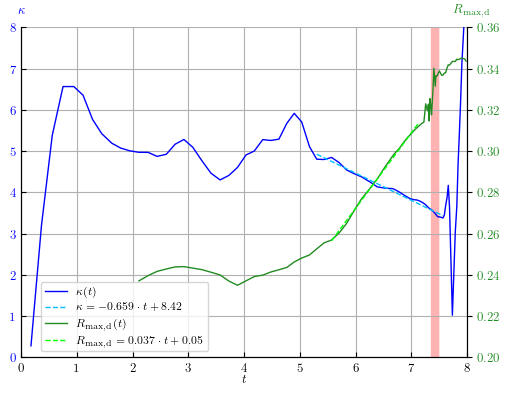

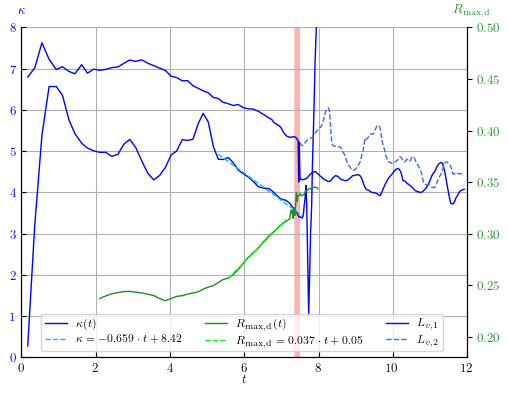

In [13]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 9,
    'axes.labelsize': 9,
    'legend.fontsize': 8,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'lines.linewidth': 1,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333 - 2*0.416667, 4]
}
matplotlib.rcParams.update(rc_params)

t = data.curvature["t"].copy()
curvature_tip = data.curvature["curvature_tip"].copy()

sm_t_curvature, sm_curvature_tip =  signal_filtering(t, curvature_tip, intervals = [(1, 2.5), (6.5, 7.5)], frac=0.2, it=10, )

rmax = data.curvature["rmax"].copy()
ind_kappa = t < 8
ind_rmax = (t > 2 ) & (t < 8)

ind_kappa_slope = (t > 5.29) & (t < 7.58)
slope_kappa, intercept_kappa, r, p, se = linregress(t[ind_kappa_slope], curvature_tip[ind_kappa_slope])
print(f"slope={slope_kappa} intercept={intercept_kappa}")
xx_kappa = np.linspace(t[ind_kappa_slope].min(), t[ind_kappa_slope].max(), num=2)
yy_kappa = slope_kappa*xx_kappa + intercept_kappa

ind_rmax_slope = (t > 5.56) & (t < 7.13)
slope_rmax, intercept_rmax, r, p, se = linregress(t[ind_rmax_slope], rmax[ind_rmax_slope])
print(f"slope={slope_rmax} intercept={intercept_rmax}")
xx_rmax = np.linspace(t[ind_rmax_slope].min(), t[ind_rmax_slope].max(), num=2)
yy_rmax = slope_rmax*xx_rmax + intercept_rmax

image_name = 'Rmax_curvature.pdf'

lines = [
    # Line(x=t[ind_kappa], y=curvature_tip[ind_kappa], name=r'$\kappa(t)$', style='solid', color='blue'),
    Line(x=sm_t_curvature[ind_kappa], y=sm_curvature_tip[ind_kappa], name=r'$\kappa(t)$', style='solid', color='blue'),
    Line(x=xx_kappa, y=yy_kappa, name=f'$\\kappa={slope_kappa:.3f}\\cdot t+{intercept_kappa:.2f}$', style='dashed', color='deepskyblue'),
    Line(x=t[ind_rmax], y=rmax[ind_rmax ], name=r'$R_{\text{max,d}}(t)$', style='solid', color='forestgreen', secondary_axis=True),
    Line(x=xx_rmax, y=yy_rmax, name=f'$R_{{\\text{{max,d}}}}={slope_rmax:.3f}\\cdot t+{intercept_rmax:.2f}$', style='dashed', color='lime', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_vsize_0']/2, name=r'$L_{v,1}$', style='solid', color='blue', secondary_axis=True),
    Line(x=data.metadata["t"], y=data.metadata['bubble_vsize_1']/2, name=r'$L_{v,2}$', style='dashed', color='royalblue', secondary_axis=True),
]

plot_matplotlib(
    lines=lines[:4],
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'center', 'rotation':0, 'color': 'black'},
    ylabel={'ylabel': r'$\kappa$', 'verticalalignment': 'top', 'rotation':0, 'color': 'blue'},
    axis_visibility={'top': False},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 8],
    yrange=[0, 8],
    xaxis={"set_label_coords": (0.5, -0.05)},
    yaxis={"set_label_coords": (0, 1.07)},
    image_name=image_name,
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[-1, 100],
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$R_{\text{max,d}}$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (1.01, 1.07)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0.2, 0.36],
        "axis_visibility": {'top': False}
    },
    legend_props={"loc": (0.08 ,0.11)},
    grid={"axis":"both"}
)

image_name = 'Rmax_curvature_Lmax.pdf'

plot_matplotlib(
    lines=lines,
    xlabel={'xlabel': r'$t$', 'horizontalalignment': 'center', 'rotation':0, 'color': 'black'},
    ylabel={'ylabel': r'$\kappa$', 'verticalalignment': 'top', 'rotation':0, 'color': 'blue'},
    axis_visibility={'top': False},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "blue"},
    xrange=[0, 12],
    yrange=[0, 8],
    xaxis={"set_label_coords": (0.5, -0.05)},
    yaxis={"set_label_coords": (0, 1.07)},
    image_name=image_name,
    path=path,
    title=None,
    vertical=[7.34769, 7.5],
    horizontal=[-1, 100],
    secondary_axis_needed=True,
    second_axis={
        'ylabel': {'ylabel': r'$R_{\text{max,d}}$', 'color': 'forestgreen', "rotation": 0}, 
        "yaxis": {"set_label_coords": (1.01, 1.07)},
        'ytick_params': {'labelcolor': 'forestgreen'},
        'yrange': [0.18, 0.5],
        "axis_visibility": {'top': False}
    },
    legend_props={"loc": (0.08 ,0.11), "ncol": 3},
    grid={"axis":"both" }
)

In [6]:
rmax[ind_rmax ]

import statsmodels.stats.api as sms
t = data.curvature["t"].copy()
ind_rmax = (t > 2 ) & (t < 8)
for label, a in [
    ("rmax", data.curvature["rmax"][ind_rmax]),
]:
    conf = sms.DescrStatsW(a).tconfint_mean(alpha=0.05)
    mean = (conf[1] + conf[0])/2
    pm = (conf[1] - conf[0])/2
    print(label, mean, pm, pm/mean)


rmax 0.2964605054618554 0.008859969230404052 0.029885833246493052


# Pressure line

In [4]:
df_line = pd.read_csv(os.path.join(path, 'pressure_line_extracted_y=0.01.csv'), sep=',', header=0)

def gradP(slope):
    return slope*997*4.117**2/0.514e-3

ind = (df_line['Points_2'].values > 11.19) & (df_line['Points_2'].values < 12.63)
slope, intercept, r, p, se = linregress(df_line['Points_2'].values[ind], df_line['p'].values[ind])
print(f"slope_drop={slope} intercept={intercept}, gradP={gradP(slope)}")
xx = np.linspace(df_line['Points_2'].values[ind].min(), df_line['Points_2'].values[ind].max())
yy = slope*xx + intercept


# indr = (df_line['Points_2'].values < 4) | (df_line['Points_2'].values > 22.8)
indr = (df_line['Points_2'].values > 22.8)
sloper, interceptr, r2, p2, se2 = linregress(df_line['Points_2'].values[indr], df_line['p'].values[indr])
print(f"sloper={sloper} intercept={interceptr}, gradP={gradP(sloper)}")
xxr = np.linspace(df_line['Points_2'].values[indr].min(), df_line['Points_2'].values[indr].max())
yyr = sloper*xxr + interceptr

indl = (df_line['Points_2'].values < 4)
slopel, interceptl, r3, p3, se3 = linregress(df_line['Points_2'].values[indl], df_line['p'].values[indl])
print(f"slopel={slopel} intercept={interceptl}, gradP={gradP(slopel)}")
xxl = np.linspace(df_line['Points_2'].values[indl].min(), df_line['Points_2'].values[indl].max())
yyl = slopel*xxl + interceptl


slope_out = 0.5*(slopel + sloper)
intercept_out = interceptl + 0.014
print(f"slope_out={slope_out} intercept={intercept_out}, gradP={gradP(slope_out)}")
xxm = np.linspace(0,30)
yym = slope_out*xxm + intercept_out

slope_drop=-0.016549538951983488 intercept=0.5832851613673316, gradP=-544101.1862150147
sloper=-0.012970114715093696 intercept=0.3894905350516876, gradP=-426420.0242860238
slopel=-0.01393227121764734 intercept=0.37306592934488536, gradP=-458052.9595528509
slope_out=-0.013451192966370519 intercept=0.3870659293448854, gradP=-442236.4919194374


Saved image /Users/evgeniisharaborin/basilisk/work/tube/res27/original_pressure_line_extracted.pdf


/var/folders/np/k_nycg1956x5prcpcqnb_rbm0000gn/T/ipykernel_90744/3948380044.py:145: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


GPL Ghostscript 10.03.0 (2024-03-06)
Copyright (C) 2024 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
$p_{\text{drop}}$=-0.0165 x+0.583
$p_{\text{out}}$=-0.0139 x+0.373


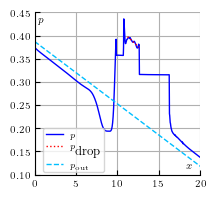

In [24]:
rc_params: dict = {
    'backend': 'pdf',
    'font.size': 5,
    'axes.labelsize': 8,
    'legend.fontsize': 5,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'lines.linewidth': 1,
    'text.usetex': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    # 'text.latex.preamble': r'\usepackage{amsmath}',
    # "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}


rc_params: dict = {
    'backend': 'pdf',
    'font.size': 7,
    'axes.labelsize': 7,
    'legend.fontsize': 6,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'lines.linewidth': 1,
    'text.usetex': True,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'text.latex.preamble': r'\usepackage{amsmath}',
    "font.family": "Times New Roman",
    'figure.figsize': [32/5.33333/2 - 2*0.416667, 2]
}
matplotlib.rcParams.update(rc_params)

lines = [
    Line(x=df_line["Points_2"], y=df_line['p'], name=r"$p$", style='solid', color='blue'),
    Line(x=xx, y=yy, name=r"$p_{\text{drop}}$", style='dotted', linestyle="--", color='red'),
    Line(x=xxm, y=yym, name=r"$p_{\text{out}}$", style='dashed', color='deepskyblue'),
]

plot_matplotlib(
    lines=lines, 
    xlabel={'xlabel': r'$x$', 'horizontalalignment': 'right', 'x': 1.005, 'rotation':0},
    ylabel={'ylabel': r'$p$', 'verticalalignment': 'top', 'y': 1, 'rotation':0, 'color': 'black'},
    xaxis={"set_label_coords": (0.95, 0.08)},
    yaxis={"set_label_coords": (0.03, 0.98)},
    xtick_params={"direction": 'in'},
    ytick_params={"direction": 'in', "labelcolor": "black"},
    # xrange=None,
    # yrange=None,
    xrange=[0, 20],
    yrange=[0.1, 0.45],
    axis_visibility={'top': False, 'right': False},
    image_name="pressure_line_extracted.pdf",
    path=path,
    title=None,
    legend_props={"loc": (0.2,0.13), "ncol": 1},
    grid={"axis":"both" }
)
print(r"$p_{\text{drop}}$" + f"={slope:0.4f} x+{intercept:0.3f}")
print(r"$p_{\text{out}}$" + f"={slopel:0.4f} x+{interceptl:0.3f}")

# Plot between solutions for inset (outdated)

In [86]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.DataFrame):
            return "DataFrame"
        elif isinstance(obj, pd.Series):
            return "Series"
        elif isinstance(obj, ModuleType):
            return "ModuleType"
        # print(obj)
        return json.JSONEncoder.default(self, obj)

In [116]:
xz = pd.read_csv("/Users/evgeniisharaborin/basilisk/work/tube/bubble_cross_section.csv", header=0)

with open("/Users/evgeniisharaborin/basilisk/work/tube/res27/_metadata_t=7.03331_another_direction.json") as f:
    json_xz = json.load(f)
    json_xz["xp"] = xz["Points_0"].values
    json_xz["yp"] = xz["Points_1"].values
    json_xz["umag"] = xz["u.x_Magnitude"].values
    json_xz["ux"] = xz["u.x_0"].values

    points = set()
    duplicate_indices = []
    for i in range(len(json_xz["xp"])):
        point = (json_xz["xp"][i], json_xz["yp"][i])
        if point in points:
            duplicate_indices.append(i)
        points.add(point)
    json_xz["xp"] = np.delete(json_xz["xp"], duplicate_indices)
    json_xz["yp"] = np.delete(json_xz["yp"], duplicate_indices)
    json_xz["ux"] = np.delete(json_xz["ux"], duplicate_indices)
    json_xz["umag"] = np.delete(json_xz["umag"], duplicate_indices)
    
with open("/Users/evgeniisharaborin/basilisk/work/tube/res27/metadata_t=7.03331.json", "w+") as f:
    json.dump(json_xz, f, cls=NumpyEncoder)

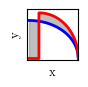

In [138]:
def plot_between(x, y, xn, yn, file_name: str):
    x1 = x.copy()
    y1 = y.copy()
    x2 = xn.copy()
    y2 = yn.copy()
    x1_min = x1.min()
    x2_min = x2.min()
    if x1_min < x2_min:
        x2 = np.insert(x2, 0, [x1_min, x2_min-0.0001])
        y2 = np.insert(y2, 0, [0, 0])
    else:
        x1 = np.insert(x1, 0, [x2_min, x1_min-0.0001])
        y1 = np.insert(y1, 0, [0, 0])
    # Combine x-coordinates
    x_union = np.union1d(x1, x2)

    # Interpolate y-values
    interp_y1 = scp_interpolate.interp1d(x1, y1, kind='linear', fill_value='extrapolate')
    interp_y2 = scp_interpolate.interp1d(x2, y2, kind='linear', fill_value='extrapolate')

    y1_interp = interp_y1(x_union)
    y2_interp = interp_y2(x_union)

    plt.figure(figsize=(2/3, 2/3))
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Plot and fill between
    plt.plot(x1, y1, 'b-', label='Curve 1', linewidth=2)
    plt.plot(x2, y2, 'r-', label='Curve 2', linewidth=2)

    plt.fill_between(x_union, y1_interp, y2_interp, color='gray', alpha=0.5, label='Filled Area')
    plt.grid(True)
    plt.xlim(-1.05, 0)
    plt.ylim(-0.05, 1.3)
    plt.xlabel("x")
    plt.ylabel("y")
    # plt.axis('equal')
    # plt.savefig(file_name, bbox_inches="tight", pad_inches=0, dpi=1200, transparent=False)
    plt.savefig(file_name[:-3] + "pdf", bbox_inches="tight", pad_inches=0, transparent=False)
    plt.show()
    plt.close()


x1 = np.linspace(-1, 0, 100)
y1 = np.sqrt(1-(-1-x1)**2)

x2 = 0.8*x1
y2 = 1.2*y1

plot_between(x1, y1, x2, y2, file_name='fit_curve_err.pdf')

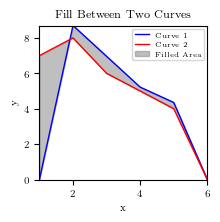

In [108]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Example data
x1 = np.array([1, 2, 3, 4, 5, 6])
y1 = np.array([7, 8, 6, 5, 4, 0])

# x2 = np.array([1, 1.9999, 2, 3, 4, 5, 6])
# y2 = np.array([0, 0, 10, 8, 6, 5, 0])
x2 = np.array([1, 1.9999, 2, 3, 4, 5, 6])
y2 = 0.87*np.array([0, 0, 10, 8, 6, 5, 0])

x1, y1, x2, y2 = x2, y2, x1, y1

# Combine x-coordinates
x_union = np.union1d(x1, x2)

# Interpolate y-values
interp_y1 = interp1d(x1, y1, kind='linear', fill_value='extrapolate')
interp_y2 = interp1d(x2, y2, kind='linear', fill_value='extrapolate')

y1_interp = interp_y1(x_union)
y2_interp = interp_y2(x_union)

# Plot and fill between
plt.plot(x1, y1, 'b-', label='Curve 1')
plt.plot(x2, y2, 'r-', label='Curve 2')

plt.fill_between(x_union, y1_interp, y2_interp, color='gray', alpha=0.5, label='Filled Area')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fill Between Two Curves')
plt.show()


# Plot 3D picture Rmaxd(l, B)

In [2]:
import sys
sys.path.append('/Users/evgeniisharaborin/basilisk/work/tube')
import logging
import numpy as np
from collections.abc import Iterable  
from pozrikidis import Config, shape_psi

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s [%(filename)s:%(lineno)d] - %(message)s",
)
logging.getLogger('matplotlib.font_manager').disabled = True

second_tip = {
    "xx_left": [],
    "yy_left": [],
    "xx_right": [],
    "yy_right": [],
    "x0": None,
    "y0": None,
}
props = {
    "mu1": 0.88e-3,
    "mu2": 0.019e-3,
    "rho1": 997,
    "rho2": 1.204,
    "sigma": 72.8e-3,
    "diam": 0.514e-3,
    "grav": 9.8,  # variable parameter
    "Umean": 4.117,
    "alpha": np.pi/6,  # variable parameter
    "s1": -1,
    "s2": 1,
    "gradp_basilisk": 542_400,  # from p_drop
    "second_tip": second_tip,
    "curvature": 3.3176104188877282
}
config = Config(props, logging)
B_basilisk = 6.6352208377754565
l_basilisk = 0.504
l = 0.1
B = 6

def calc_Rmaxd(l, B, config):
    config.set_B(B)
    if isinstance(l, Iterable):
        Sigma_psi_arr = []
        for l_i in l:
            _, Sigma_psi_i = shape_psi(l_i, config)
            Sigma_psi_arr.append(Sigma_psi_i)
        return Sigma_psi_arr
    _, Sigma_psi = shape_psi(l, config)
    return Sigma_psi[-1]
calc_Rmaxd(l, B, config)

2024-07-10 18:37:49,920 - INFO [pozrikidis.py:43] - B=6.6352208377754565, x0=None, y0=None
/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


0.17946687346484533

In [3]:
Nl = 81
NB = 201
l_arr = np.linspace(0.05, 4.05, Nl)
B_arr = np.linspace(0.05, 10.05, NB)
Rmaxd = np.zeros((NB, Nl))
ll = []
BB = []
RR = []
for i, B in enumerate(B_arr):
    for j, l in enumerate(l_arr):
        ll.append(l)
        BB.append(B)
        Rmaxd[i][j] = calc_Rmaxd(l, B, config)
        RR.append(Rmaxd[i][j])

In [278]:
# doctor for bad point
l_target = 0.05
B_target = 1.5
ind_target = np.argmin(np.abs(np.array(BB) - B_target))
if abs(BB[ind_target] - B_target) + abs(ll[ind_target] - l_target) < 0.0001:
    print(ind_target, ll[ind_target], BB[ind_target], l_arr[ind_target % Nl], B_arr[ind_target // Nl])
    R_target = calc_Rmaxd(l, B, config)
    print(R_target, RR[ind_target])
    RR[ind_target] = R_target
    Rmaxd[ind_target // Nl][ind_target % Nl] = R_target

/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning:

The following arguments have no effect for a chosen solver: `min_step`.

/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning:

At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.



2349 0.05 1.5000000000000002 0.05 1.5000000000000002
0.1990851584978035 0.1990851584978035


In [277]:
l_arr[ind_target % Nl], B_arr[ind_target // Nl], Rmaxd[ind_target // Nl][ind_target % Nl]

(0.05, 1.5000000000000002, -3573.2198705253822)

In [269]:
import pandas as pd
df_data = pd.DataFrame({"l": ll, "B": BB, "R": RR})

In [279]:
fig = go.Figure(go.Surface(
    contours = {
        "x": {"show": True, "start": l_basilisk, "end": l_basilisk*1.01, "size": 1, "color":"aquamarine"},
        "y": {"show": True, "start": B_basilisk, "end": B_basilisk*1.01, "size": 1, "color":"pink"},
        "z": {"show": True, "start": 0.5, "end": 0.51, "size": 1, "color":"white"}
    },
    x = l_arr,
    y = B_arr,
    z = Rmaxd,
    colorscale="Jet"#"Viridis"
))
camera = dict(
    eye=dict(x=0, y=1.5, z=1.)
)

fig.update_layout(
    scene = {
        "xaxis": {"nticks": 20},
        "zaxis": {"nticks": 4},
        'camera_eye': {"x": 0, "y": -1, "z": 0.5},
        "aspectratio": {"x": 1, "y": 1, "z": 0.2},
        "xaxis_title": "l",
        "yaxis_title": "B",
        "zaxis_title": "R",  # r"$R_{\text{max,d}}$"
        # "xaxis_range": [0.1,2],
        # "yaxis_range": [0.1,10],
        # "zaxis_range": [0,0.5],
    },
    # width=1000,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    autosize=True,
    scene_camera=camera
)
# Update the hovertemplate
fig.update_traces(
    hovertemplate='l: %{x}<br>B: %{y}<br>R: %{z}<extra></extra>'
)
fig.show()

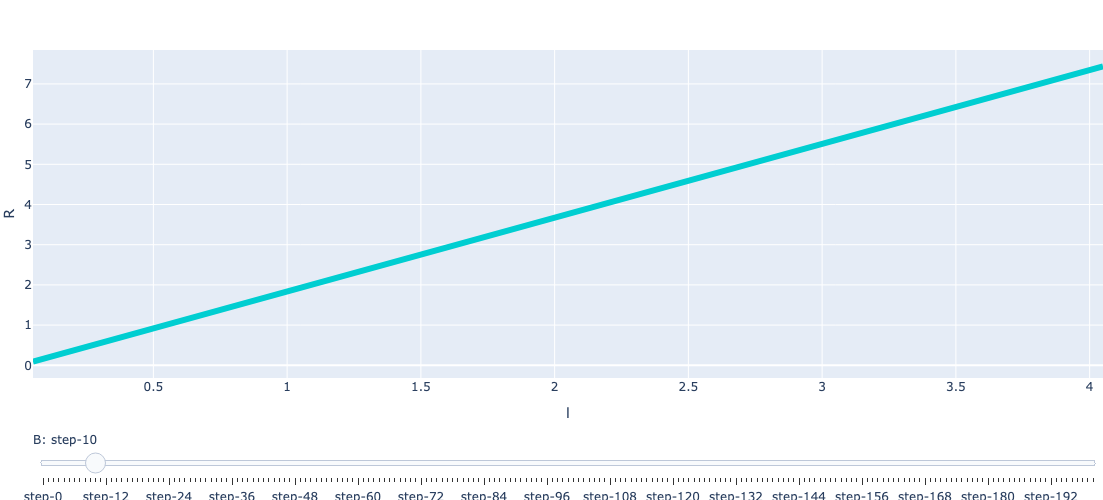

In [4]:
import plotly.graph_objects as go
import numpy as np

# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for i, B in enumerate(B_arr):
    # y = calc_Rmaxd(l_arr, B, config)
    rmax = Rmaxd[i]
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
            name="B = " + str(B),
            x=l_arr,
            y=rmax
        )
    )

# Make 0th trace visible
fig.data[0].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Slider switched to B[{i}]: {B_arr[i]:.2f}"}],  # layout attribute
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "B: "},
    pad={"t": 50},
    steps=steps,
)]

fig.update_layout(
    sliders=sliders,
    xaxis_title="l",
    yaxis_title="R",
    # width=1000,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    autosize=True,
)

fig.show()

/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



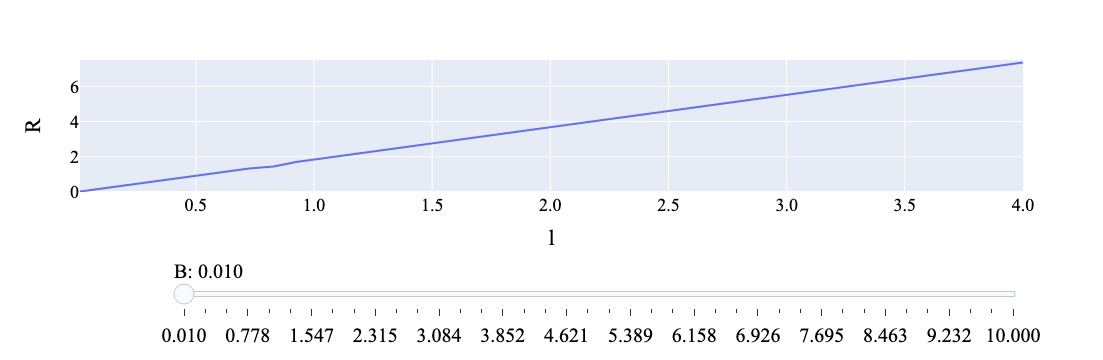

In [168]:
import plotly.express as px

fig = px.line(df_data, x="l", y="R", animation_frame="B", hover_name="B")

fig["layout"].pop("updatemenus") # optional, drop animation buttons
sliders = [
    {
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {"prefix": "B: "},
        "pad": {"b": 10},
        "font": {"size": 20},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "label": f"{float(step['name']):.3f}", 
                 "method": "animate", 
                "args": [[step["name"]], {"mode": "immediate", "transition": {"duration": 300}}]
            } for step in fig.frames
        ]
    }
]
fig.update_layout(
    font=dict(
        family="Times New Roman, Times, serif",
        size=18,
        color="Black"
    ),
    xaxis=dict(
        tickformat=".1f"  # This sets the y-axis tick format to 2 decimals
    ),
    yaxis_range=[0,7.5],
    sliders=sliders

)
fig.show()

/Users/evgeniisharaborin/basilisk/work/tube/.venv/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



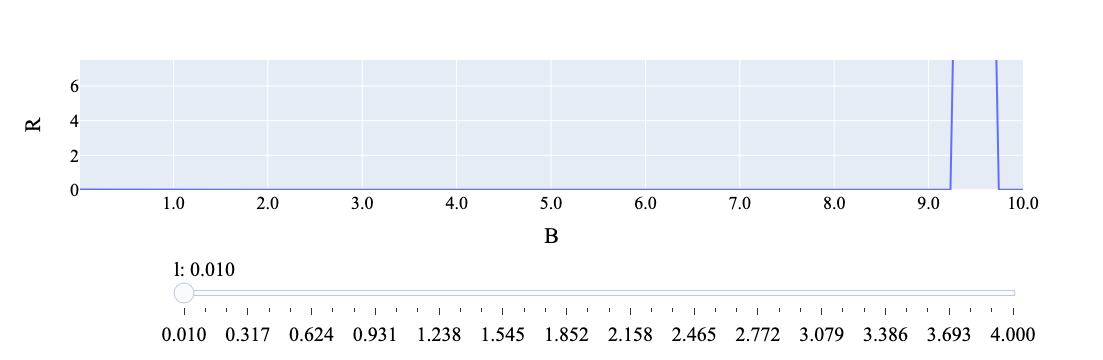

In [169]:
import plotly.express as px

fig = px.line(
    df_data, x="B", y="R", animation_frame="l", hover_name="l", 
    # log_x=True, log_y=True
)

fig["layout"].pop("updatemenus") # optional, drop animation buttons
sliders = [
    {
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {"prefix": "l: "},
        "pad": {"b": 10},
        "font": {"size": 20},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": [
            {
                "label": f"{float(step['name']):.3f}", 
                "method": "animate", 
                "args": [[step["name"]], {"mode": "immediate", "transition": {"duration": 300}}]
            } for step in fig.frames
        ]
    }
]
fig.update_layout(
    font=dict(
        family="Times New Roman, Times, serif",
        size=18,
        color="Black"
    ),
    yaxis_range=[0,7.5],
    xaxis=dict(
        tickformat=".1f"  # This sets the y-axis tick format to 2 decimals
    ),
        sliders=sliders,
)

fig.show()

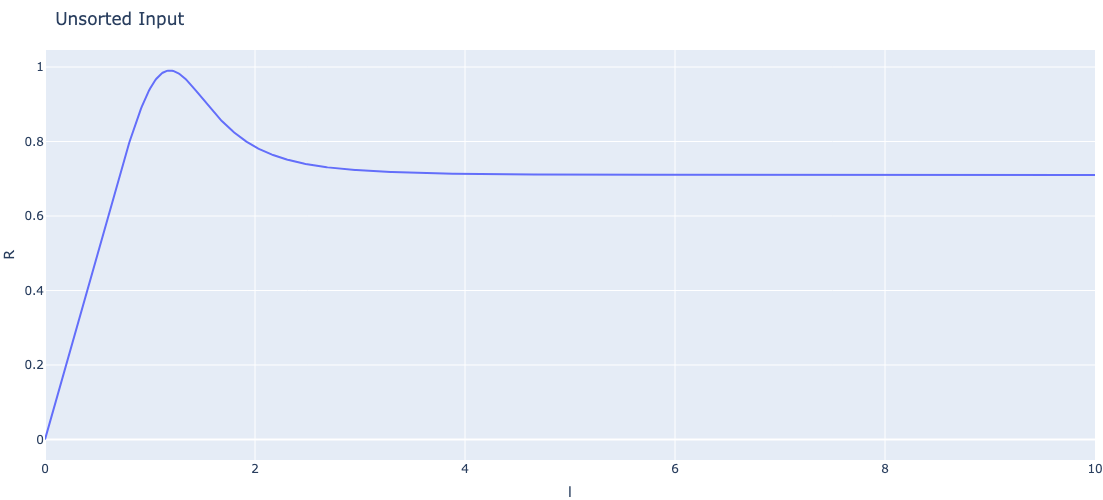

In [194]:
import plotly.express as px
import pandas as pd

x_tmp = np.linspace(0, 10, 1000)
y_tmp = (4*x_tmp + 0.71*x_tmp**6)/(4 + x_tmp**6)
df = pd.DataFrame(dict(
    x = x_tmp,
    y = y_tmp
))
fig = px.line(df, x="x", y="y", title="Unsorted Input") 
fig.update_layout(
    xaxis_title="l",
    yaxis_title="R",
    # width=1000,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    autosize=True,
)
fig.show()



In [ ]:
import numpy as np

X = 2 * np.random.randn(100, 2)
y = np.cos(X[:, 1]) + X[:, 0] ** 2 - 0.5

from pysr import PySRRegressor

model = PySRRegressor(
    model_selection="best",  # Result is mix of simplicity+accuracy
    niterations=40,
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(x, y) = (x - y)^2",
    # ^ Custom loss function (julia syntax)
)

model.fit(X, y)

print(model)

array([[1.00000000e-06, 1.00000000e-06],
       [8.16336327e-02, 1.00000000e-06],
       [1.63266265e-01, 1.00000000e-06],
       ...,
       [3.83673473e+00, 1.00000000e+01],
       [3.91836737e+00, 1.00000000e+01],
       [4.00000000e+00, 1.00000000e+01]])

In [1]:
import numpy as np
lmin = 0.1
lmax = 1
Bmin = 1
Bmax = 10
X = []
y = []

for i, B in enumerate(B_arr):
    for j, l in enumerate(l_arr):
        if lmin <= l <= lmax and Bmin <= B <= Bmax:
            X.append([l, B])
            # y.append(Rmaxd[i][j])
            y.append((l*B - B**2 + B**4)/(1 + B + B**4))
X = np.array(X)
y = np.array(y)
# X = np.c_[ll, BB]
# y = np.asarray(RR)

from pysr import PySRRegressor

model = PySRRegressor(
    model_selection="best",  # Result is mix of simplicity+accuracy
    niterations=100,
    # batching=True,
    # batch_size=1000,
    binary_operators=["+", "*", "-", "/", "^"],
    unary_operators=[
        # "cos",
        # "sin",
        # "exp",        
        # "erf",
        "cube",
        "square",
        "inv(x) = 1/x",
        "quad(x) = x^4"
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x, "quad": lambda x: x**4},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(x, y) = (x - y)^2",
    # ^ Custom loss function (julia syntax)
    constraints={'^': (-1, 1)}
)

model.fit(X, y)

print(model)

NameError: name 'B_arr' is not defined

In [ ]:
model.equations

In [5]:
model.equations.loc[0]

NameError: name 'model' is not defined

In [642]:
# import numpy as np
# import matplotlib.pyplot as plt
# from tsmoothie.smoother import *

# x = np.linspace(0,2*np.pi,100)
# y = np.sin(x) + np.random.random(100) * 0.2

# # operate smoothing
# smoother = ConvolutionSmoother(window_len=5, window_type='ones')
# smoother.smooth(y)

# # generate intervals
# low, up = smoother.get_intervals('sigma_interval', n_sigma=2)

# # plot the smoothed timeseries with intervals
# plt.figure(figsize=(11,6))
# plt.plot(smoother.smooth_data[0], linewidth=3, color='blue')
# plt.plot(smoother.data[0], '.k')
# plt.fill_between(range(len(smoother.data[0])), low[0], up[0], alpha=0.3)

In [ ]:
# def dict_calc(metadata1, metadata2):
#     for k in list(metadata1.keys()):
#         if isinstance(metadata1[k], dict):
#             if k.isnumeric() and int(k) < 4 or not k.isnumeric():
#                 print("dict", k)
#                 dict_calc(metadata1[k], metadata2[k])
#         else:
#             if k not in ["parts", "xp", "yp", "contour_Np"]:
#                 # print(k)
#                 print(f"{k}: {metadata1[k]} {metadata2[k]}: delta={(np.array(metadata2[k]) - np.array(metadata1[k]))/np.array(metadata2[k])}")

# dict_calc(metadata_12, metadata_13)

In [644]:
# import numpy as np

# def compute_curvature_from_ordered_points(x, y):
#     # Calculate first derivatives
#     dx = np.gradient(x)
#     dy = np.gradient(y)
    
#     # Calculate second derivatives
#     ddx = np.gradient(dx)
#     ddy = np.gradient(dy)
    
#     # Calculate curvature
#     curvature = np.abs(dx * ddy - dy * ddx) / np.power(dx**2 + dy**2, 1.5)
    
#     return curvature

# def compute_normals_from_ordered_points(x, y):
#     # Compute dx and dy using finite differences
#     dx = np.gradient(x)
#     dy = np.gradient(y)
    
#     # Normalize dx and dy to get the unit tangent vector at each point
#     tangent_lengths = np.sqrt(dx**2 + dy**2)
#     dx_unit = dx / tangent_lengths
#     dy_unit = dy / tangent_lengths
    
#     # Rotate the tangent vector by 90 degrees to get the normal vector
#     # For a vector (dx, dy), rotating by 90 degrees gives (-dy, dx)
#     nx = -dy_unit
#     ny = dx_unit
    
#     return nx, ny

# def plot_circle_with_curvature(x0, y0, curvature, nx0, ny0):
#     # Calculate the radius from the curvature
#     radius = 1 / np.abs(curvature)
    
#     # Generate angles
#     angles = np.linspace(0, 2 * np.pi, 100)
    
#     # Calculate circle coordinates
#     circle_x = x0 + radius * (nx0 + np.cos(angles))
#     circle_y = y0 + radius * (-ny0 + np.sin(angles))
#     return circle_x, circle_y

# # Example usage:
# x = np.linspace(0, 2*np.pi, 100)
# y = np.sin(x)

# curvature = compute_curvature_from_ordered_points(x, y)
# nx, ny = compute_normals_from_ordered_points(x, y)
# p = 25
# x0, y0 = x[p], y[p]
# circle_x, circle_y = plot_circle_with_curvature(x0, y0, curvature[p], nx[p], ny[p])

# # Plotting the curve and its curvature
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 6))
# plt.axis('equal')
# # plt.subplot(1, 2, 1)

# plt.plot(x, y, label='Curve')
# # Plotting
# plt.plot(circle_x, circle_y, label=f'Circle with curvature {curvature}')
# plt.scatter([x0], [y0], color='red', label='Point on curve') # Point on the curve
# plt.title('Curve')
# plt.xlabel('x')
# plt.ylabel('y')

# # plt.subplot(1, 2, 2)
# # plt.plot(x, curvature, label='Curvature', color='red')
# # plt.title('Curvature of the Curve')
# # plt.xlabel('x')
# # plt.ylabel('Curvature')

# plt.tight_layout()
# plt.show()
# nx[p], ny[p], 1/curvature[p]